# 1. Importacion de librarias y configuracion de seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler, StandardScaler
import requests
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

# 2. Carga de dataset

In [3]:
df = pd.read_csv("data/train.csv")
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

# 3. Prueba de normalidad

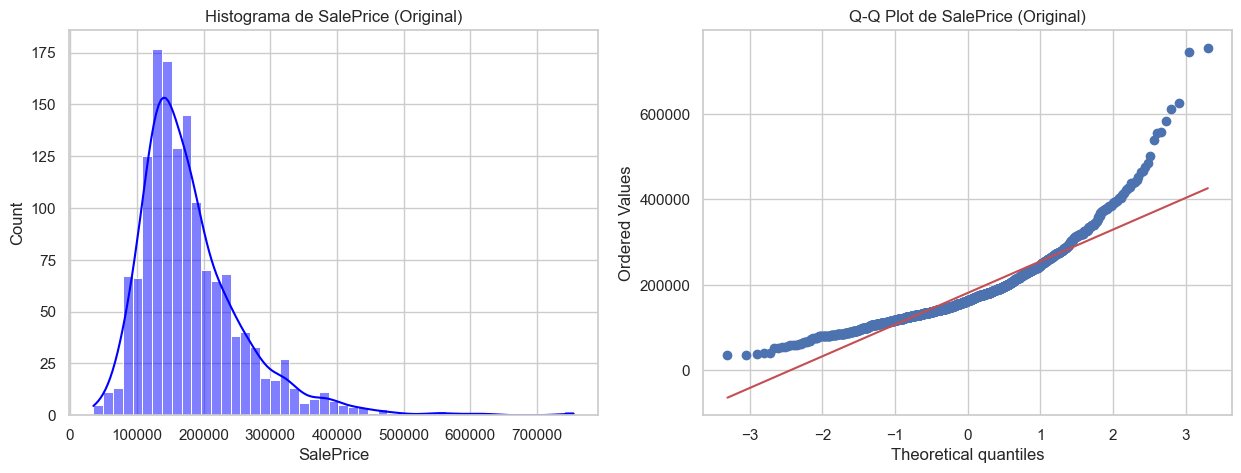

In [4]:
# Variable Objetivo: SalePrice

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
sns.histplot(df['SalePrice'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Histograma de SalePrice (Original)')

# Q-Q Plot
probplot(df['SalePrice'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot de SalePrice (Original)')

plt.show()

# 4. Prueba de Shapiro-Wilk

Prueba de Shapiro-Wilk: p-valor = 0.0000
La muestra NO parece Gaussiana (no-normal).


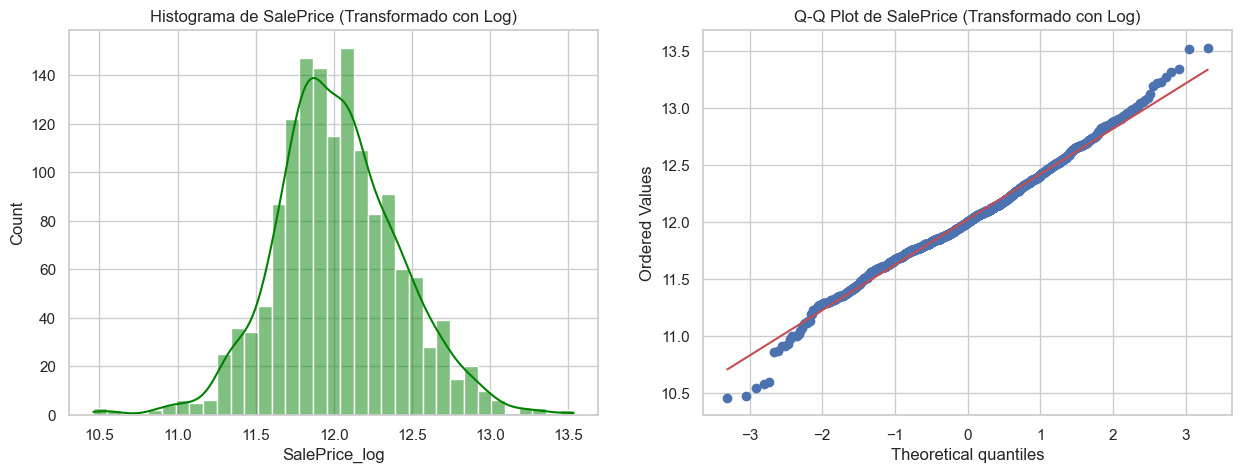

Prueba de Shapiro-Wilk (Log): p-valor = 0.0000
La muestra transformada NO parece Gaussiana (no-normal). (Pero visualmente mucho mejor)


In [5]:
sample_size = min(len(df['SalePrice']), 1000)
stat, p = shapiro(df['SalePrice'].sample(sample_size, random_state=1))
print(f'Prueba de Shapiro-Wilk: p-valor = {p:.4f}')
if p > 0.05:
    print('La muestra parece Gaussiana (normal).')
else:
    print('La muestra NO parece Gaussiana (no-normal).')


# Aplica transformación log(x+1)
df['SalePrice_log'] = np.log1p(df['SalePrice'])

# 1.2 Analizar la distribución transformada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
sns.histplot(df['SalePrice_log'], kde=True, ax=axes[0], color='green')
axes[0].set_title('Histograma de SalePrice (Transformado con Log)')

# Q-Q Plot
probplot(df['SalePrice_log'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot de SalePrice (Transformado con Log)')

plt.show()

# Prueba de Shapiro-Wilk en datos transformados
sample_size_log = min(len(df['SalePrice_log']), 1000)
stat, p = shapiro(df['SalePrice_log'].sample(sample_size_log, random_state=1))
print(f'Prueba de Shapiro-Wilk (Log): p-valor = {p:.4f}')
if p > 0.05:
    print('La muestra transformada parece Gaussiana (normal).')
else:
    print('La muestra transformada NO parece Gaussiana (no-normal). (Pero visualmente mucho mejor)')

# 5. Discretización de Caractrerísticas

In [ ]:
# A. Discretización por Cuantiles (Equal-Frequency) para 'LotArea'
print("\n--- 2A. Discretización de 'LotArea' ---")
# Copiamos para evitar SettingWithCopyWarning
df_discretized = df[['LotArea']].copy()

# Llenar valores nulos si los hubiera
df_discretized['LotArea'] = df_discretized['LotArea'].fillna(df_discretized['LotArea'].median())

ef = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', subsample=None)
df_discretized['LotArea_ef'] = ef.fit_transform(df_discretized[['LotArea']]).astype(int)

print(df_discretized.head())


# B. One-Hot Encoding para 'OverallQual' (Calidad General)
print("\n--- 2B. One-Hot Encoding de 'OverallQual' ---")
encoder = OneHotEncoder(sparse_output=False, dtype=int)
qual_encoded = encoder.fit_transform(df[['OverallQual']])

# Crear un DataFrame con los nombres de las categorías
df_oh = pd.DataFrame(qual_encoded, columns=[f"Qual_{int(i)}" for i in encoder.categories_[0]])

print(df_oh.head())


--- 2A. Discretización de 'LotArea' ---
   LotArea  LotArea_ef
0     8450           1
1     9600           2
2    11250           2
3     9550           2
4    14260           3

--- 2B. One-Hot Encoding de 'OverallQual' ---
   Qual_1  Qual_2  Qual_3  Qual_4  Qual_5  Qual_6  Qual_7  Qual_8  Qual_9  \
0       0       0       0       0       0       0       1       0       0   
1       0       0       0       0       0       1       0       0       0   
2       0       0       0       0       0       0       1       0       0   
3       0       0       0       0       0       0       1       0       0   
4       0       0       0       0       0       0       0       1       0   

   Qual_10  
0        0  
1        0  
2        0  
3        0  
4        0  


c:\Users\franc\Desktop\GSTI\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


# 6. Escalado de Características

In [7]:
# A. Escalado Min-Max para 'GrLivArea' (Area habitable)
print("\n--- 3A. Escalado Min-Max de 'GrLivArea' ---")
df_scaled = df[['GrLivArea']].copy()
scaler_minmax = MinMaxScaler()

df_scaled['GrLivArea_MinMax'] = scaler_minmax.fit_transform(df_scaled[['GrLivArea']])

print(df_scaled.head())


# B. Estandarización (Z-score) para 'TotalBsmtSF' (Área del sótano)
print("\n--- 3B. Escalado Z-score de 'TotalBsmtSF' ---")
df_scaled_z = df[['TotalBsmtSF']].copy()
# Rellenar NaNs con 0 (ya que Z-score no maneja NaNs y 0 es un valor lógico para "sin sótano")
df_scaled_z['TotalBsmtSF'] = df_scaled_z['TotalBsmtSF'].fillna(0)

scaler_zscore = StandardScaler()

df_scaled_z['TotalBsmtSF_Zscore'] = scaler_zscore.fit_transform(df_scaled_z[['TotalBsmtSF']])

print(df_scaled_z.head())


--- 3A. Escalado Min-Max de 'GrLivArea' ---
   GrLivArea  GrLivArea_MinMax
0       1710          0.259231
1       1262          0.174830
2       1786          0.273549
3       1717          0.260550
4       2198          0.351168

--- 3B. Escalado Z-score de 'TotalBsmtSF' ---
   TotalBsmtSF  TotalBsmtSF_Zscore
0          856           -0.459303
1         1262            0.466465
2          920           -0.313369
3          756           -0.687324
4         1145            0.199680
